# Trabalho I - Introdução ao Processamento Digital de Imagens
Processamento de imagens no domínio espacial.

### Ambiente

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_titled_imgs(imgs: list) -> None:
  _, ax = plt.subplots(1, len(imgs), figsize=(12, 12), dpi=96)
  for i, img in enumerate(imgs):
    ax[i].title.set_text(img[1])
    if len(img[0].shape) == 3:
      ax[i].imshow(img[0][:, :, ::-1])
    else:
      ax[i].imshow(img[0], cmap='gray')

  plt.show()


### Materiais

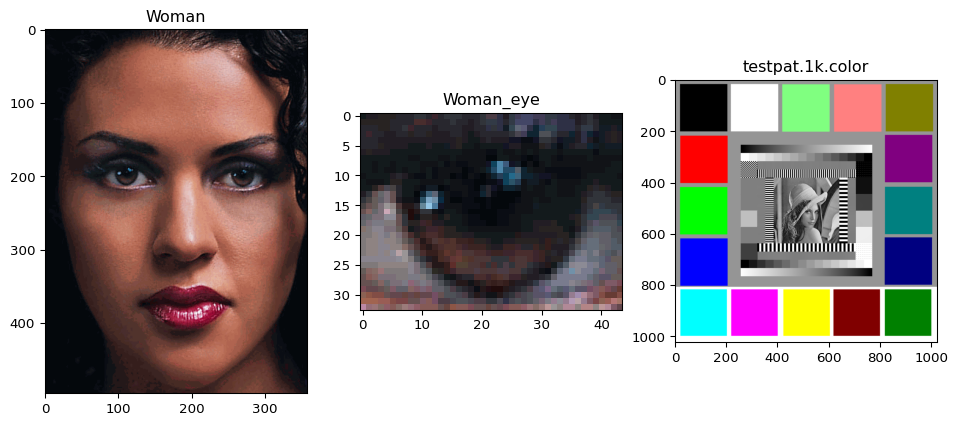

In [2]:
img_woman = cv2.imread('assets/Woman.png')
img_woman_eye = cv2.imread('assets/Woman_eye.png')
img_testpat = cv2.imread('assets/testpat.1k.color.tif')

plot_titled_imgs([
    (img_woman, 'Woman'),
    (img_woman_eye, 'Woman_eye'),
    (img_testpat, 'testpat.1k.color')
])


### 1. Conversão RGB-YIQ-RGB

In [3]:
def bgr2yiq(img: np.ndarray) -> np.ndarray:
    res = np.zeros(img.shape, dtype=float)
    h, w, _ = img.shape

    for y in range(h):
        for x in range(w):
            pb, pg, pr = img[y, x]

            py = 0.299 * pr + 0.587 * pg + 0.114 * pb
            pi = 0.596 * pr - 0.274 * pg - 0.322 * pb
            pq = 0.211 * pr - 0.523 * pg + 0.312 * pb

            res[y, x] = [py, pi, pq]

    return res


def yiq2bgr(img: np.ndarray) -> np.ndarray:
    res = np.zeros(img.shape, dtype=int)
    h, w, _ = img.shape

    for y in range(h):
        for x in range(w):
            py, pi, pq = img[y, x]

            pb = 1.000 * py - 1.106 * pi + 1.703 * pq
            pg = 1.000 * py - 0.272 * pi - 0.647 * pq
            pr = 1.000 * py + 0.956 * pi + 0.621 * pq

            res[y, x] = np.clip(np.round([pb, pg, pr]), 0, 255)

    return res


Resultados

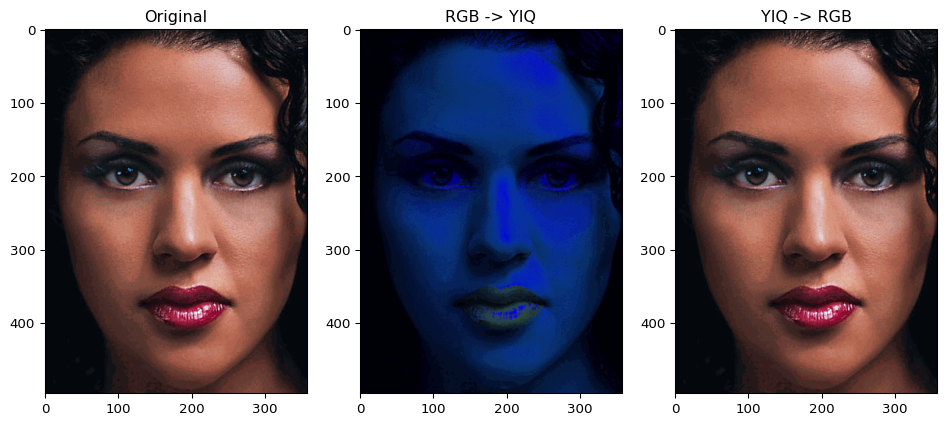

In [4]:
img_woman_yiq = bgr2yiq(img_woman)
img_woman_bgr = yiq2bgr(img_woman_yiq)

plot_titled_imgs([
    (img_woman, 'Original'),
    (np.clip(img_woman_yiq.astype(int), 0, 255), 'RGB -> YIQ'),
    (img_woman_bgr, 'YIQ -> RGB')
])


### 2. Negativo em RGB (banda a banda) e em YIQ (apenas na banda Y) com posterior conversão para RGB.

In [5]:
def negative_bgr(img: np.ndarray) -> np.ndarray:
    res = np.zeros(img.shape, img.dtype)
    h, w, _ = img.shape

    for y in range(h):
        for x in range(w):
            res[y, x] = 255 - img[y, x]

    return res


def negative_yiq(img: np.ndarray) -> np.ndarray:
    res = np.zeros(img.shape, img.dtype)
    h, w, _ = img.shape

    for y in range(h):
        for x in range(w):
            # [0] -> Y channel
            res[y, x][0] = 255 - img[y, x][0]

    return res


Resultados

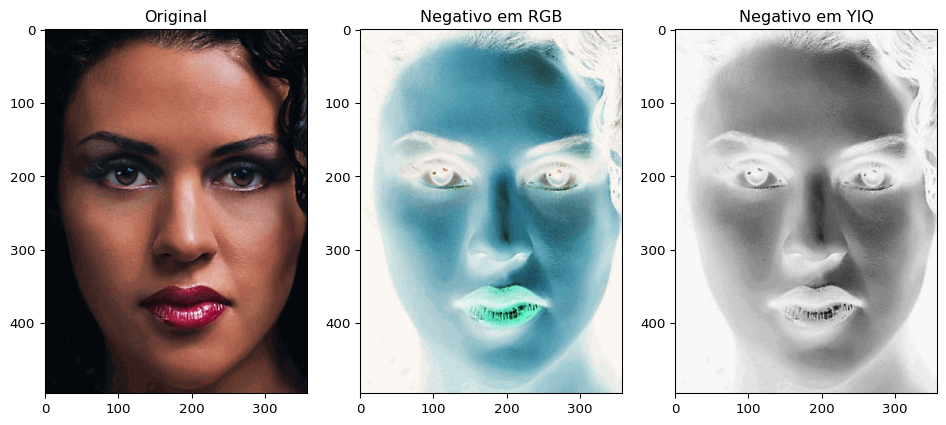

In [6]:
img_woman_negative_bgr = negative_bgr(img_woman_bgr)
img_woman_negative_yiq = yiq2bgr(negative_yiq(img_woman_yiq))

plot_titled_imgs([
    (img_woman, 'Original'),
    (img_woman_negative_bgr, 'Negativo em RGB'),
    (img_woman_negative_yiq, 'Negativo em YIQ')
])


### Histogram Expansion

In [7]:
def expand_histogram255(img: np.ndarray) -> np.ndarray:
    res = np.zeros(img.shape, img.dtype)
    h, w, _ = img.shape
    
    channels = cv2.split(img)
    minb, maxb, _, _ = cv2.minMaxLoc(channels[0])
    ming, maxg, _, _ = cv2.minMaxLoc(channels[1])
    minr, maxr, _, _ = cv2.minMaxLoc(channels[2])

    def exphist(val, min, max):
      return (val - min) / (max - min) * 255

    for y in range(h):
        for x in range(w):
            pb, pg, pr = img[y, x]

            pb = exphist(pb, minb, maxb)
            pg = exphist(pg, ming, maxg)
            pr = exphist(pr, minr, maxr)

            res[y, x] = [pb, pg, pr]

    return res


### 3. Correlação m x n sobre R, G e B, com offset, e filtro e pivô definidos em um arquivo .txt a parte. Para visualização do resultado do Sobel, utilize valor absoluto seguido por expansão de histograma para [0, 255]. 

In [8]:
def load_correlation_filter(filter: str) -> tuple[np.ndarray, int]:
    kernel = None
    offset = None

    with open(f'assets/filter_{filter}.txt') as f:
        lines = [l.strip() for l in f.readlines()]
        lines = [l for l in lines if l and l[0] != '#']

        # Parse offset
        offset = float(lines[0])

        # Parse kernel
        kernel = np.zeros((len(lines) - 1, len(lines) - 1), dtype=float)
        for row in range(1, len(lines)):
            curr = lines[row].split(',')
            for col in range(len(curr)):
                kernel[row - 1, col] = float(curr[col])

    return kernel, offset


def correlation_filter(img: np.ndarray, kernel: np.ndarray, offset: int, flip_kernel: bool = True, expand_histogram: bool = True) -> np.ndarray:
    res = np.zeros(img.shape, dtype=img.dtype)
    h, w, c = img.shape
    kw, kh = kernel.shape

    # Edges
    ex = kw // 2
    ey = kh // 2

    # Flip the kernel
    if flip_kernel:
        kernel = np.flipud(np.fliplr(kernel))

    # Add zero padding
    padded = np.zeros((h + ex * 2, w + ey * 2, c), img.dtype)
    padded[ey:-ey, ex:-ex, :] = img

    for y in range(h):
        for x in range(w):
            # Extracts a block to which the filter applies
            block = padded[y: y+kh, x:x+kw, :]

            # Initializes the new pixel with the given offset
            npx = np.repeat(offset, c)

            # Applies element-wise multiplication in each channel
            for i in range(c):
                npx[i] = (kernel * block[:, :, i]).sum()

            res[y, x] = np.clip(npx, 0, 255)

    return expand_histogram255(res) if expand_histogram else res


Resultados:

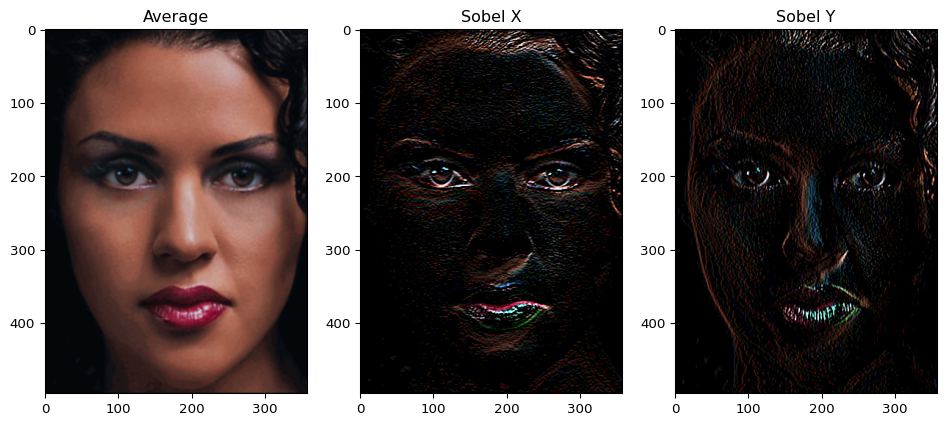

In [9]:
filters = [('avg', 'Average'), ('sbx', 'Sobel X'), ('sby', 'Sobel Y')]

_, ax = plt.subplots(1, len(filters), figsize=(12, 12), dpi=96)
for i, filter in enumerate(filters):
    kernel, offset = load_correlation_filter(filter[0])

    flip_kernel = filter[0] != 'avg'
    expand_hist = filter[0] != 'avg'

    ax[i].title.set_text(filter[1])
    ax[i].imshow(correlation_filter(img_woman_bgr, kernel,
                 offset, flip_kernel, expand_hist)[:, :, ::-1])

plt.show()


### 4. Filtro mediana MxN, com M e N ímpares, sobre a banda Y do YIQ. 

In [10]:
def median_filter(img: np.ndarray, m: int, n: int) -> np.ndarray:
    assert(m % 2 != 0 and n % 2 != 0)

    h, w, _ = img.shape

    # Edges
    ex = int(np.floor(m / 2))
    ey = int(np.floor(n / 2))

    # Add zero-padding
    padded = cv2.copyMakeBorder(
        img, ey, ey, ex, ex, cv2.BORDER_CONSTANT, value=0)

    # Y-channel accumulator
    accy = np.zeros(m * n, img.dtype)

    res = img.copy()

    for y in range(ey, h - ey):
        for x in range(ex, w - ex):
            i = 0

            for fy in range(n):
                for fx in range(m):
                    accy[i] = padded[y + fy - ey, x + fx - ex][0]
                    i += 1

            # Sort the Y-channels in order to get the median value
            accy.sort()
            
            # Set the median
            res[y, x][0] = accy[len(accy) // 2]

    return res


Resultados

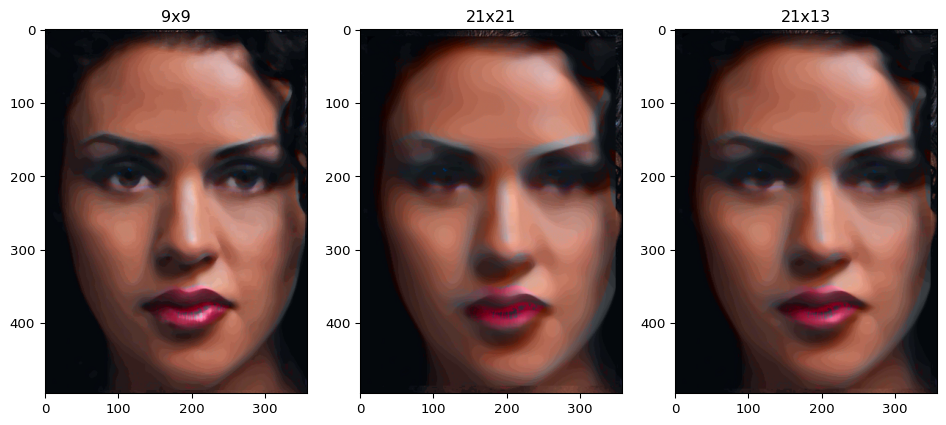

In [11]:
MEDIAN_SIZES = [((9, 9), '9x9'), ((21, 21), '21x21'), ((21, 13), '21x13')]

_, ax = plt.subplots(1, len(MEDIAN_SIZES), figsize=(12, 12), dpi=96)
for i, size in enumerate(MEDIAN_SIZES):
    ax[i].title.set_text(size[1])
    ax[i].imshow(yiq2bgr(median_filter(
        img_woman_yiq, size[0][0], size[0][1]))[:, :, ::-1])

plt.show()


In [12]:
def correlate(img: np.ndarray, tpl: np.ndarray, depth: int, output_mask: bool = False):
    tpl_h, tpl_w, _ = tpl.shape

    # Find the most correlated area
    match = cv2.matchTemplate(img, tpl, cv2.TM_CCORR_NORMED)
    
    mask_radius = max(tpl_h, tpl_w)

    for _ in range(depth):
        _, _, _, maxloc = cv2.minMaxLoc(match)

        # Apply a circular mask on the correlated area
        match = cv2.circle(match, maxloc, mask_radius, 0, -1)

        rect_pt1 = maxloc
        rect_pt2 = (maxloc[0] + tpl_w, maxloc[1] + tpl_h)

        # Draw a rectangle on the correlated area
        img = cv2.rectangle(img, rect_pt1, rect_pt2, (255, 255, 255), 2)

    return match if output_mask else expand_histogram255(img)


Resultados:

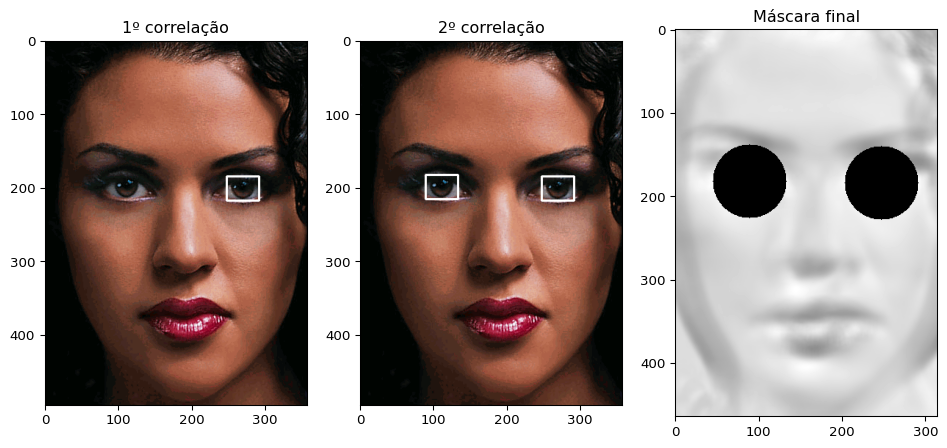

In [13]:
plot_titled_imgs([
    (correlate(img_woman.copy(), img_woman_eye, 1), '1º correlação'),
    (correlate(img_woman.copy(), img_woman_eye, 2), '2º correlação'),
    (correlate(img_woman.copy(), img_woman_eye, 2, True), 'Máscara final')
])
